<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment11/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy with CNN**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [3]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.Normalize((0.1307,),(0.3081,))                    # 이미지를 텐서로 변형합니다.
])

transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,),(0.3081,))            
])

In [4]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform_test)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform_train)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])


type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


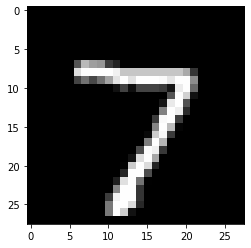

In [5]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [6]:
learning_rate = 0.003
training_epochs = 600
batch_size = 256

In [7]:
train_loader = DataLoader(dataset = data_train, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [9]:
model = classification().to(device)

In [10]:
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# 4. Training
<hr>

In [11]:
total_batch= len(train_loader)

In [12]:
print(total_batch)

40


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()

      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [15]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 1.075572610 Testing Loss: 0.235367462  Training Acc: 0.731347680 Testing Acc: 0.953679025
Epoch: 02 Training Loss: 0.336793602 Testing Loss: 0.129538327  Training Acc: 0.922070324 Testing Acc: 0.963768780
Epoch: 03 Training Loss: 0.227584481 Testing Loss: 0.076060720  Training Acc: 0.944824219 Testing Acc: 0.977687240
Epoch: 04 Training Loss: 0.186333999 Testing Loss: 0.066079855  Training Acc: 0.951562524 Testing Acc: 0.979742885
Epoch: 05 Training Loss: 0.157339141 Testing Loss: 0.061407227  Training Acc: 0.960253894 Testing Acc: 0.981654406
Epoch: 06 Training Loss: 0.140221223 Testing Loss: 0.058838457  Training Acc: 0.962792993 Testing Acc: 0.982092202
Epoch: 07 Training Loss: 0.119133785 Testing Loss: 0.057022508  Training Acc: 0.967968762 Testing Acc: 0.982701659
Epoch: 08 Training Loss: 0.117874362 Testing Loss: 0.069719166  Training Acc: 0.968164086 Testing Acc: 0.979787230
Epoch: 09 Training Loss: 0.122137167 Testing Loss: 0.059070207  Training Acc: 0.

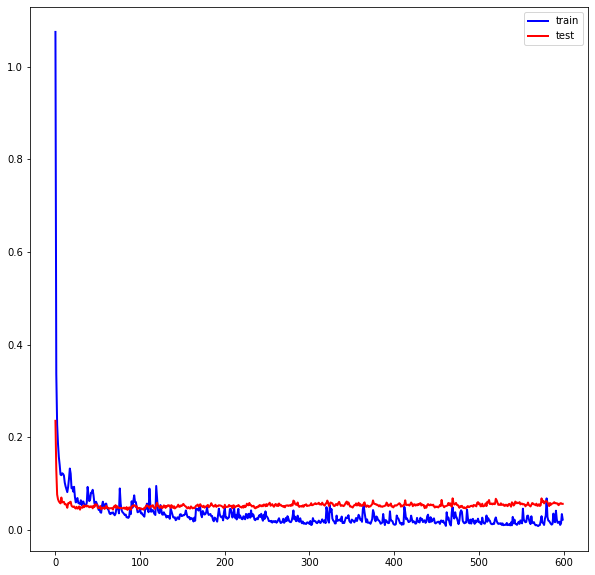

In [16]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

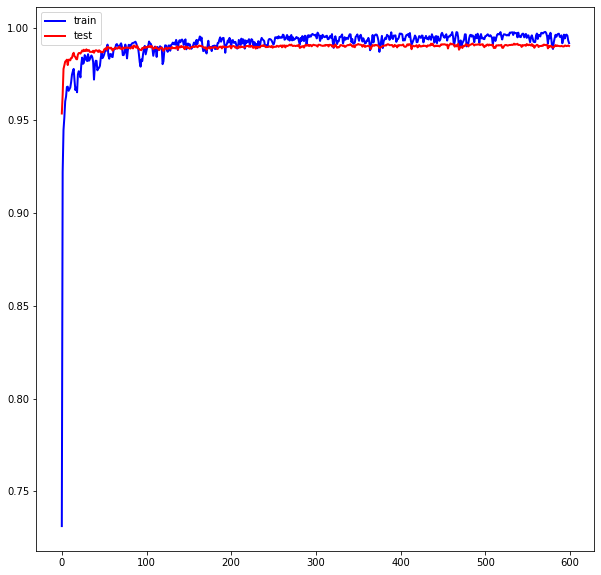

In [17]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [18]:
print("training loss    %.2f" %(L_train[-1]))
print("testing loss     %.2f" %(L_test[-1]))
print("training acc    %.2f" %(A_train[-1]))
print("testing acc     %.2f" %(A_test[-1]))

training loss    0.02
testing loss     0.06
training acc    0.99
testing acc     0.99


# 5. Output
<hr>

## 1. Plot the training and testing losses over epochs

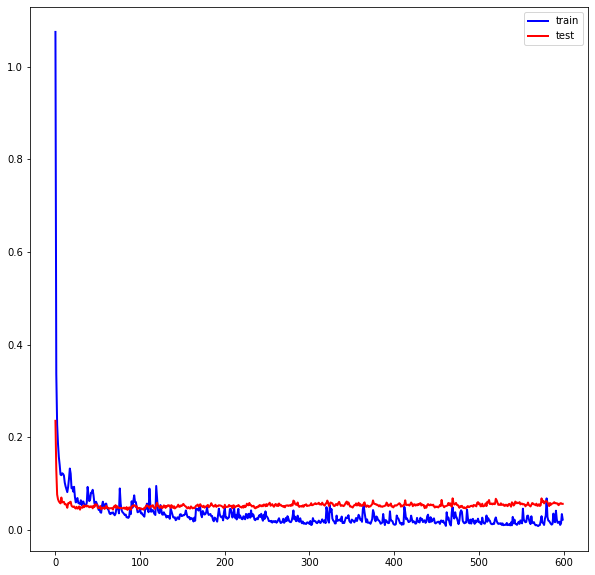

In [19]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 2. Plot the training and testing accuracies over epochs

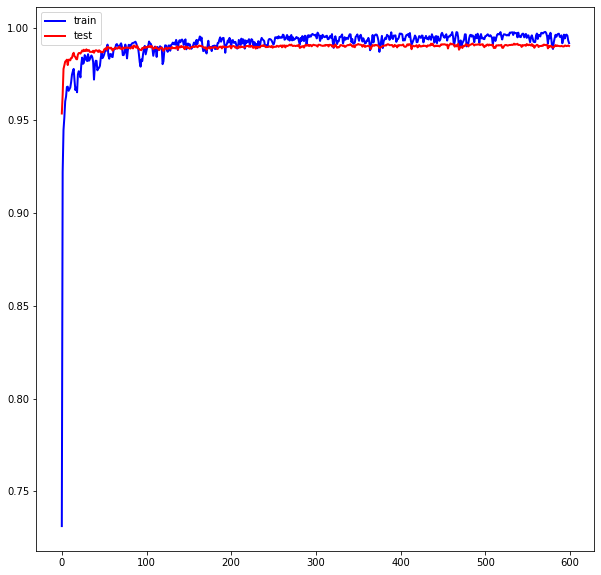

In [20]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 3.  Print the final training and testing losses at convergence 

In [21]:
print("loss")
print("train    %.2f" %(L_train[-1]))
print("test     %.2f" %(L_test[-1]))

loss
train    0.02
test     0.06


## 4. Print the final training and testing accuracies at convergence

In [22]:
print("Accuracy")
print("train    %.5f, %.2f" %(A_train[-1], A_train[-1]))
print("test     %.5f, %.2f" %(A_test[-1], A_test[-1]))

Accuracy
train    0.99160, 0.99
test     0.99008, 0.99


## 5. Print the testing accuracies within the last 10 epochs

In [23]:
for i in range(-10, 0):
  print(f"Epoch = {len(A_test) + i + 1} Acc: %.5f" %(A_test[i]))


Epoch = 591 Acc: 0.99009
Epoch = 592 Acc: 0.98993
Epoch = 593 Acc: 0.98978
Epoch = 594 Acc: 0.98985
Epoch = 595 Acc: 0.99033
Epoch = 596 Acc: 0.99026
Epoch = 597 Acc: 0.98999
Epoch = 598 Acc: 0.99017
Epoch = 599 Acc: 0.99031
Epoch = 600 Acc: 0.99008
